--- Initializing Data for Efficient Frontier ---
Market data loaded and risk-free rate extracted.
Daily returns calculated and NaNs removed.
Expected returns and covariance matrix calculated.


--- Step 1: Simulating Random Portfolios ---
Generated 20000 random portfolios.


--- Step 2: Finding Minimum Volatility Portfolio (MVP) ---
Minimum Volatility Portfolio:
  Return: -42.1286%
  Volatility: 23.0321%
  Weights: {'MSFT': 0.07, 'AAPL': 0.0084, 'JPM': 0.8934, 'TSLA': 0.0282}


--- Step 3: Finding Maximum Sharpe Ratio Portfolio ---
Maximum Sharpe Ratio Portfolio:
  Return: 56.9143%
  Volatility: 64.9709%
  Sharpe Ratio: -0.0937
  Weights: {'MSFT': 0.0553, 'AAPL': 0.0206, 'JPM': 0.0236, 'TSLA': 0.9006}


--- Step 4: Visualizing the Efficient Frontier ---


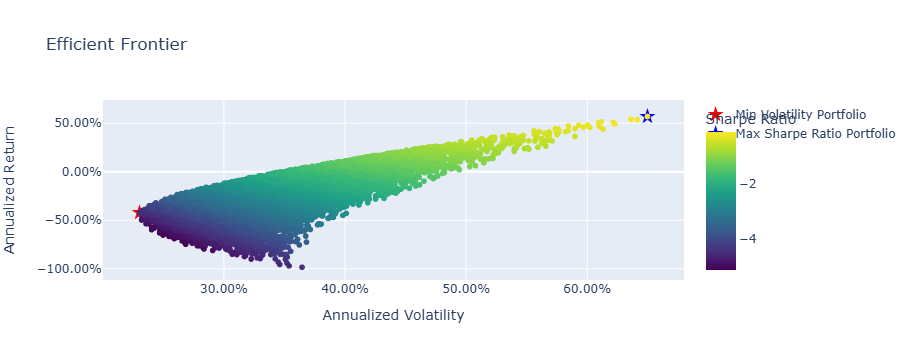


--- Further Steps for Precise Efficient Frontier (Conceptual) ---
The above plot approximates the efficient frontier by simulating random portfolios.
For a mathematically precise efficient frontier, you would typically use optimization techniques.
This involves minimizing portfolio variance for a target return (or maximizing Sharpe ratio).
Libraries like `scipy.optimize.minimize` can be used for this purpose.
You would define an objective function (e.g., portfolio volatility to minimize) and constraints (e.g., weights sum to 1, target return, no short-selling).
By varying the target return, you can trace out the complete efficient frontier.
This approach would also allow for more complex constraints (e.g., sector limits).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats # For beta calculation, though not strictly needed for EF itself
import plotly.express as px # For interactive plot of the EF

# --- Configuration (Re-using from previous script for self-containment) ---
excel_file_name = 'Market Data.xlsx'
sheet_name = 'Sheet1'
stock_price_cols = ['MSFT', 'AAPL', 'JPM', 'TSLA']
market_index_col = 'S&P 500'
risk_free_rate_col = 'Risk-Free Rate'

# --- Step 0: Data Loading and Initial Calculations (from previous script) ---
# This part is included so the efficient frontier code can run independently.
# If you are running this after the previous script, you can comment out Step 0
# and ensure 'returns_df', 'average_historical_returns', and 'covariance_matrix'
# are in your global scope or passed to this script.

print("--- Initializing Data for Efficient Frontier ---")
try:
    df = pd.read_excel(excel_file_name, sheet_name=sheet_name, index_col='date', parse_dates=True)
    required_cols = stock_price_cols + [market_index_col, risk_free_rate_col]
    if not all(col in df.columns for col in required_cols):
        missing_cols = [col for col in required_cols if col not in df.columns]
        raise ValueError(f"Missing required columns in the Excel file: {missing_cols}.")
    risk_free_rate = df[risk_free_rate_col].iloc[0] # Taking the first risk-free rate
    print("Market data loaded and risk-free rate extracted.")
except Exception as e:
    print(f"Error loading initial data: {e}")
    exit()

returns_df = pd.DataFrame(index=df.index)
for col in stock_price_cols:
    returns_df[f'{col}_Return'] = df[col].pct_change()
returns_df[f'{market_index_col}_Return'] = df[market_index_col].pct_change()
returns_df.dropna(inplace=True)
print("Daily returns calculated and NaNs removed.")

# Use historical average returns as expected returns for MPT
expected_returns = returns_df[[f'{col}_Return' for col in stock_price_cols]].mean()
# Use the covariance of returns
covariance_matrix = returns_df[[f'{col}_Return' for col in stock_price_cols]].cov()
print("Expected returns and covariance matrix calculated.")
print("\n")

# --- Efficient Frontier Calculation ---

# Define the number of portfolios to simulate
num_portfolios = 20000 # More portfolios give a smoother curve

# Define the number of trading days in a year for annualization
annualization_factor = 252

# Initialize lists to store portfolio data
portfolio_returns = []
portfolio_volatility = []
portfolio_weights = []
portfolio_sharpe_ratio = []

# Get the names of the stock return columns
asset_return_cols = [f'{col}_Return' for col in stock_price_cols]
num_assets = len(stock_price_cols)

# --- Function to calculate portfolio return ---
# This function calculates the annualized expected return of a portfolio
# given its weights and the expected returns of individual assets.
def calculate_portfolio_return(weights, expected_returns, annualization_factor):
    # Sum of (weight * expected return of asset) for all assets
    return np.sum(weights * expected_returns) * annualization_factor

# --- Function to calculate portfolio volatility ---
# This function calculates the annualized volatility (standard deviation) of a portfolio
# given its weights and the covariance matrix of asset returns.
def calculate_portfolio_volatility(weights, cov_matrix, annualization_factor):
    # Portfolio variance = weights_transpose * covariance_matrix * weights
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    # Portfolio volatility = square root of portfolio variance, then annualized
    return np.sqrt(portfolio_variance) * np.sqrt(annualization_factor)

# --- Simulate Random Portfolios ---
print("--- Step 1: Simulating Random Portfolios ---")
for _ in range(num_portfolios):
    # Generate random weights for each asset
    weights = np.random.random(num_assets)
    # Normalize weights so they sum to 1 (no short-selling allowed here)
    weights /= np.sum(weights)

    # Calculate portfolio return and volatility
    p_return = calculate_portfolio_return(weights, expected_returns, annualization_factor)
    p_volatility = calculate_portfolio_volatility(weights, covariance_matrix, annualization_factor)

    # Calculate Sharpe Ratio (Risk-Free Rate is taken from the Excel file)
    # Sharpe Ratio = (Portfolio Return - Risk-Free Rate) / Portfolio Volatility
    # Ensure risk_free_rate is also annualized if the portfolio_return is annualized
    # For simplicity, we'll use the daily risk_free_rate and annualize it here too for the ratio.
    sharpe_ratio = (p_return - (risk_free_rate * annualization_factor)) / p_volatility

    # Store the results
    portfolio_returns.append(p_return)
    portfolio_volatility.append(p_volatility)
    portfolio_weights.append(weights)
    portfolio_sharpe_ratio.append(sharpe_ratio)

print(f"Generated {num_portfolios} random portfolios.")
print("\n")

# Convert lists to NumPy arrays for easier manipulation
portfolio_returns = np.array(portfolio_returns)
portfolio_volatility = np.array(portfolio_volatility)
portfolio_sharpe_ratio = np.array(portfolio_sharpe_ratio)
portfolio_weights = np.array(portfolio_weights)

# --- Step 2: Find the Minimum Volatility Portfolio (MVP) ---
print("--- Step 2: Finding Minimum Volatility Portfolio (MVP) ---")
# Find the index of the portfolio with the lowest volatility
min_vol_idx = np.argmin(portfolio_volatility)

# Get the return, volatility, and weights of the MVP
mvp_return = portfolio_returns[min_vol_idx]
mvp_volatility = portfolio_volatility[min_vol_idx]
mvp_weights = portfolio_weights[min_vol_idx]

print(f"Minimum Volatility Portfolio:")
print(f"  Return: {mvp_return:.4%}")
print(f"  Volatility: {mvp_volatility:.4%}")
print(f"  Weights: {dict(zip(stock_price_cols, mvp_weights.round(4)))}")
print("\n")

# --- Step 3: Find the Portfolio with the Maximum Sharpe Ratio ---
print("--- Step 3: Finding Maximum Sharpe Ratio Portfolio ---")
# Find the index of the portfolio with the highest Sharpe Ratio
max_sharpe_idx = np.argmax(portfolio_sharpe_ratio)

# Get the return, volatility, and weights of the Max Sharpe Ratio portfolio
max_sharpe_return = portfolio_returns[max_sharpe_idx]
max_sharpe_volatility = portfolio_volatility[max_sharpe_idx]
max_sharpe_weights = portfolio_weights[max_sharpe_idx]

print(f"Maximum Sharpe Ratio Portfolio:")
print(f"  Return: {max_sharpe_return:.4%}")
print(f"  Volatility: {max_sharpe_volatility:.4%}")
print(f"  Sharpe Ratio: {portfolio_sharpe_ratio[max_sharpe_idx]:.4f}")
print(f"  Weights: {dict(zip(stock_price_cols, max_sharpe_weights.round(4)))}")
print("\n")

# --- Step 4: Visualize the Efficient Frontier ---
print("--- Step 4: Visualizing the Efficient Frontier ---")

# Create a DataFrame for plotting (optional, but good for plotly)
plot_df = pd.DataFrame({
    'Volatility': portfolio_volatility,
    'Return': portfolio_returns,
    'Sharpe Ratio': portfolio_sharpe_ratio
})

# Use Plotly Express for an interactive plot
fig = px.scatter(plot_df, x='Volatility', y='Return', color='Sharpe Ratio',
                 title='Efficient Frontier',
                 labels={'Volatility': 'Annualized Volatility', 'Return': 'Annualized Return'},
                 color_continuous_scale=px.colors.sequential.Viridis,
                 hover_data={'Volatility': ':.2%', 'Return': ':.2%', 'Sharpe Ratio': ':.2f'})

# Add the Minimum Volatility Portfolio
fig.add_scatter(x=[mvp_volatility], y=[mvp_return], mode='markers',
                marker=dict(size=12, color='red', symbol='star'),
                name='Min Volatility Portfolio',
                hoverinfo='text',
                hovertext=f'MVP<br>Return: {mvp_return:.2%}<br>Volatility: {mvp_volatility:.2%}')

# Add the Maximum Sharpe Ratio Portfolio
fig.add_scatter(x=[max_sharpe_volatility], y=[max_sharpe_return], mode='markers',
                marker=dict(size=12, color='blue', symbol='star'),
                name='Max Sharpe Ratio Portfolio',
                hoverinfo='text',
                hovertext=f'Max Sharpe<br>Return: {max_sharpe_return:.2%}<br>Volatility: {max_sharpe_volatility:.2%}<br>Sharpe: {portfolio_sharpe_ratio[max_sharpe_idx]:.2f}')

# Update layout for better readability
fig.update_layout(
    xaxis_tickformat=".2%",
    yaxis_tickformat=".2%",
    hovermode="closest",
    coloraxis_colorbar=dict(title="Sharpe Ratio")
)

fig.show()

# --- Further Optimization (Conceptual - not implemented in full code) ---
print("\n--- Further Steps for Precise Efficient Frontier (Conceptual) ---")
print("The above plot approximates the efficient frontier by simulating random portfolios.")
print("For a mathematically precise efficient frontier, you would typically use optimization techniques.")
print("This involves minimizing portfolio variance for a target return (or maximizing Sharpe ratio).")
print("Libraries like `scipy.optimize.minimize` can be used for this purpose.")
print("You would define an objective function (e.g., portfolio volatility to minimize) and constraints (e.g., weights sum to 1, target return, no short-selling).")
print("By varying the target return, you can trace out the complete efficient frontier.")
print("This approach would also allow for more complex constraints (e.g., sector limits).")